[[ 1.          0.02        0.          0.        ]
 [ 0.          1.         -0.01800165  0.        ]
 [ 0.          0.          1.          0.02      ]
 [ 0.          0.          0.41688634  1.        ]] [[ 0.        ]
 [ 0.04387699]
 [ 0.        ]
 [-0.08547465]]
[[34.35661658 24.71339086 89.5450231  18.7847591 ]]
double c[] = {34.356617, 24.713391, 89.545023, 18.784759};


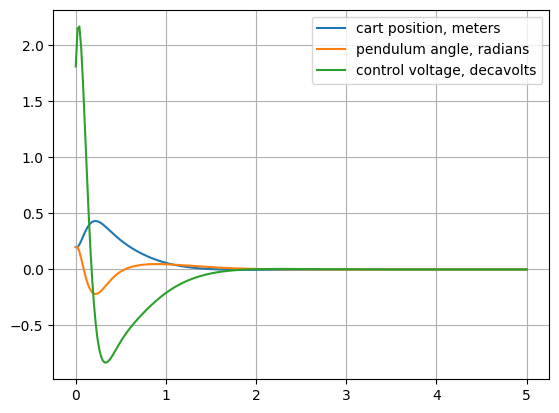

In [ ]:
#!/usr/bin/python

# example from https://github.com/ssloy/tutorials/blob/master/tutorials/pendulum/lqr.py
# this code is solve ricati equation for INFINITE LQR
# NOTE. this code block isn't made by me. I mean, continuous LQR is not by me.

import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

def dlqr(A,B,Q,R):
    """
    Solve the discrete time lqr controller.
    x[k+1] = A x[k] + B u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    return -K

l = .22 # rod length is 2l
m = (2*l)*(.006**2)*(3.14/4)*7856 # rod 6 mm diameter, 44cm length, 7856 kg/m^3
M = .4
dt = .02 # 20 ms
g = 9.8

A = np.matrix([[1, dt, 0, 0],[0,1, -(3*m*g*dt)/(7*M+4*m),0],[0,0,1,dt],[0,0,(3*g*(m+M)*dt)/(l*(7*M+4*m)),1]])
B = np.matrix([[0],[7*dt/(7*M+4*m)],[0],[-3*dt/(l*(7*M+4*m))]])


print (A,B)

Q = np.matrix("1 0 0 0; 0 .0001 0 0 ; 0 0 1 0; 0 0 0 .0001")
R = np.matrix(".0005")


K = dlqr(A,B,Q,R)
print (K)
print ("double c[] = {%f, %f, %f, %f};" % (K[0,0], K[0,1], K[0,2], K[0,3]))

nsteps = 250
time = np.linspace(0, 5, nsteps, endpoint=True)   # corrected this part. dt*nsteps = 0.02*250 = 5. not 2 (it was 2 originally)
xk = np.matrix(".2 ; 0 ; .2 ; 0")   # initial value

X = []
T = []
U = []

for t in time:
    uk = K*xk
    X.append(xk[0,0]) # position of cart
    T.append(xk[2,0]) # pendulum angle
    v = xk[1,0]
    force = uk[0,0]
    accel = force/(M+m)
    u = ((1-.404)*v + dt*accel)/.055/10
    U.append(u) # control input
    xk = A*xk + B*uk

plt.plot(time, X, label="cart position, meters")
plt.plot(time, T, label='pendulum angle, radians')
plt.plot(time, U, label='control voltage, decavolts')

plt.legend(loc='upper right')
plt.grid()
plt.show()

0.2


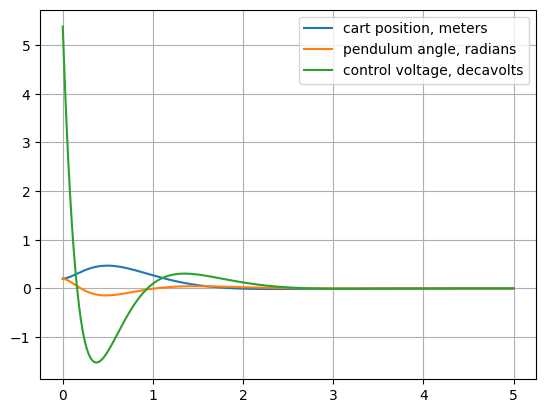

In [36]:
# for time invarient A,B,Q,R
# we will observe for 250steps and time step is 0.02s
# Q and R will use themselves on above code

# Purpose is implement finite LQR with above example.

import numpy as np
import matplotlib.pyplot as plt

l = .22 # rod length is 2l
m = (2*l)*(.006**2)*(3.14/4)*7856 # rod 6 mm diameter, 44cm length, 7856 kg/m^3
M = .4
dt = .02 # 20 ms
g = 9.8

A = np.array([[1, dt, 0, 0],
             [0, 1, -(3*m*g*dt)/(7*M+4*m),0],
             [0,0,1,dt],
             [0,0,(3*g*(m+M)*dt)/(l*(7*M+4*m)),1]])

B = np.array([[0],[7*dt/(7*M+4*m)],[0],[-3*dt/(l*(7*M+4*m))]])

Q = np.array([[1,0, 0, 0],
             [0, .0001, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, .0001]])

R = np.array([[.05]])

nsteps = 250
time = np.linspace(0, 5, nsteps, endpoint=True)
X0 = np.array([[.2] ,[0] , [.2] , [0]])   # initial value. 4 by 1 matrix.
# X0 = np.array([[5] ,[5] , [5] , [5]])   # initial value. 4 by 1 matrix.

X = np.zeros((nsteps+1))    # X contains initial value. X is same variable with P in PDF (Position)
theta = np.zeros((nsteps+1)) # theta contains initial value.
U = np.zeros((nsteps))      # U is contains u0 to u_{nsteps-1} : total element is "nsteps"

K = np.zeros((nsteps,1,4))

# =========================================================== code for LQR ===========================================================
S = Q   # backwards setting for last step
for i in range(nsteps-1,-1,-1):
  K[i] = -(np.linalg.inv(R+B.T@S@B))@(B.T@S@A)
  S = Q+(K[i].T)@R@K[i] + ((A+B@K[i]).T)@S@(A+B@K[i])

Xk = X0
X[0] = X0[0][0]    # only contains initial
theta[0] = X0[2][0]    # only constains angle

print(X[0])
for i in range(nsteps):
  U[i] = (K[i]@Xk)[0,0]   # U는 element가 스칼라이고, 행렬곱 결과는 2차원 행렬이라 스칼라값을 뽑기
  Xk = A@Xk + B*U[i]
  X[i+1] = Xk[0][0]
  theta[i+1] = Xk[2][0]

# =========================================================== code for Plot ===========================================================

plt.plot(time, X[1:], label="cart position, meters")
plt.plot(time, theta[1:], label='pendulum angle, radians')
plt.plot(time, U, label='control voltage, decavolts')

plt.legend(loc='upper right')
plt.grid()
plt.show()

# 구현 끝!
  # 한계 : LQR이라 제약조건을 extrinsic하게 포함하지 못함
  # time invarient라서 time varient system에 대해서도 적용해볼만함
  # 해당코드에서는 명시적으로 objective funciton이 작성되지 않음. 이는 LQR PDF를 2차로 설정한 것임.
  # 지금 선형 근사한 식으로 시뮬레이션을 돌리고 있기에 초기값을 큰 값을 줘도 항상 수렴하지만, 실제 비선형 시스템에선 이 시뮬레이션을 통해 나온 입력이 유효하지 않을 수 있음
    # Of course, whatever initial value I setted, U made by this code will make linearized system converge, wheares real(nonlinear) system.

# Q,R의 값을 변화시켜가며 결과가 어떻게 나오는지 확인 가능함

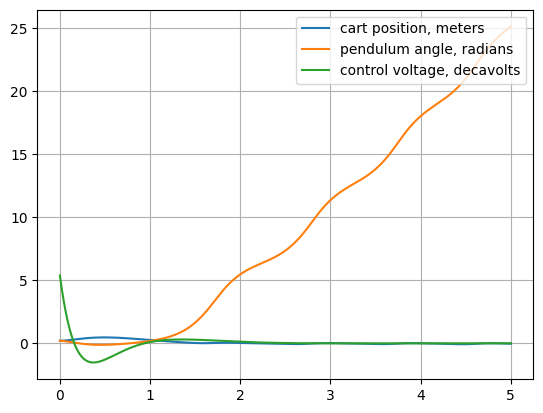

You can test the code by varying initial values.
And you will recognize that even if difference of reference point of linearize and setted initial point is only 0.2, real system(nonlinear system) will be diverge


In [40]:
# purpose of this code is checking validity of LQR optimal input when adapting real nonlinear system
# input is U. and U is calculated from linearized system code that is above this code. (You can get U by implementing above code. Don't forget to revising initial value!)

I = 4/3*m*(l**2)

X0 = np.array([[.2] ,[0] , [.2] , [0]])   # initial value.
# X0 = np.array([[5.0] ,[5.0] , [5.0] , [5.0]])   # initial value. 4 by 1 matrix.
  # to check validity, initial value have to be same with above code's

X = np.zeros((nsteps+1))
X[0] = X0[0][0]

theta = np.zeros((nsteps+1))
theta[0] = X0[2][0]


XK = X0
XKplus1 = np.zeros((4,1))
dXK = np.zeros((4,1))

# this func returns acceleration and angular acceleration.
def cal_accs(u,omega,theta):
  D = (l**2)*(m**2)*(np.cos(theta)) - (I+m*(l**2))*(M+m)
  Q = (l**2)*(m**2)*g*np.sin(theta)*np.cos(theta) - (I+m*(l**2))*(u+l*m*(omega**2)*np.sin(theta))
  Z = -(M+m)*l*np.sin(theta)*m*g + l*m*np.cos(theta)*(u+l*m*(omega**2)*np.sin(theta))
  return Q/D, Z/D
# D,Q,Z is explained on PDF


for i in range(nsteps):
  acc, angular_acc = cal_accs(U[i],XK[3][0],XK[2][0])
  dXK[0] = XK[1][0]
  dXK[1] = acc
  dXK[2] = XK[3][0]
  dXK[3] = angular_acc

  XK[0][0] += dXK[0][0]*dt
  XK[1][0] += dXK[1][0]*dt
  XK[2][0] += dXK[2][0]*dt
  XK[3][0] += dXK[3][0]*dt

  X[i+1] = XK[0][0]
  theta[i+1] = XK[2][0]



plt.plot(time, X[1:], label="cart position, meters")
plt.plot(time, theta[1:], label='pendulum angle, radians')
plt.plot(time, U, label='control voltage, decavolts')

plt.legend(loc='upper right')
plt.grid()
plt.show()

print("You can test the code by varying initial values.")
print("And you will recognize that even if difference of reference point of linearize and setted initial point is only 0.2, real system(nonlinear system) will be diverge.")
print("Of course, if there is no difference between them, nonlinear system that used calculated from linearized system would be to diverge.")